In [1]:
from os.path import join
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn.functional as F
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from IPython.display import display, clear_output
from pycocotools.coco import COCO


from torchmetrics.classification import MulticlassJaccardIndex
import time

# Load the COCO 2017 test set
coco = COCO('/home/samyakr2/multilabel/data/coco/annotations/instances_val2017.json')
image_dir = '/home/samyakr2/multilabel/data/coco/val2017/'

device = "cuda" if torch.cuda.is_available() else "cpu"

#### LOAD MODEL HERE


model, _ = clip.load("CS-RN101", device=device)
preprocess_img =  Compose([Resize((448, 448), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

preprocess_target =  Compose([ToTensor()])



image_ids = coco.getImgIds()

cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
cat_id_to_name = {cat['id']: cat['name'] for cat in cats}


classnames = ['background',"person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                           "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
                           "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
                           "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
                           "kite",
                           "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
                           "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich",
                           "orange",
                           "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
                           "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
                           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                           "teddy bear", "hair drier", "toothbrush"]

all_texts = classnames[1:]

with torch.no_grad():
    text_feats = clip.encode_text_with_prompt_ensemble(model, all_texts, device, prompt_templates = ['a photo of a {}.'])


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [5]:
import torch.nn as nn
sizes = [512, 384, 256]

layers_text = []
for i in range(len(sizes) - 2):
    layers_text.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
    layers_text.append(nn.BatchNorm1d(sizes[i + 1]))
    layers_text.append(nn.ReLU(inplace=True))
layers_text.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
text_projector = nn.Sequential(*layers_text)

size_img = [512, 256]
layers_img = []
# for i in range(len(sizes) - 2):
#     layers_img.append(nn.Linear(size_img[i], size_img[i + 1], bias=False))
#     layers_img.append(nn.BatchNorm1d(197))
#     layers_img.append(nn.ReLU(inplace=True))
layers_img.append(nn.Linear(size_img[-2], size_img[-1], bias=False))
text_projector = nn.Sequential(*layers_text).to(device)

image_projector = nn.Sequential(*layers_img).to(device)


# model_path = '/home/samyakr2/Redundancy/DualCoOp/output/coco_with_SSL_90_0.003R/model_best.pth.tar'
model_path = '/home/samyakr2/Redundancy/DualCoOp/output/voc2007-DualCoop-RN101SSL_posneg_p1.0-0.05R/model_best.pth.tar'
# model_path = '/home/samyakr2/CLIP_Surgery/weights_coco/RN101_0.005.pth.tar'
state_dict = torch.load(model_path)

projector_weights_text = {}
projector_weights_img = {}

for kays in state_dict['state_dict'].keys():
    if 'text_projector' in kays:
        projector_weights_text[kays[15:]] = state_dict['state_dict'][kays]
    if 'image_projector' in kays:
        projector_weights_img[kays[16:]] = state_dict['state_dict'][kays]


text_projector.load_state_dict(projector_weights_text)
image_projector.load_state_dict(projector_weights_img)

<All keys matched successfully>

  0%|          | 0/5 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE:


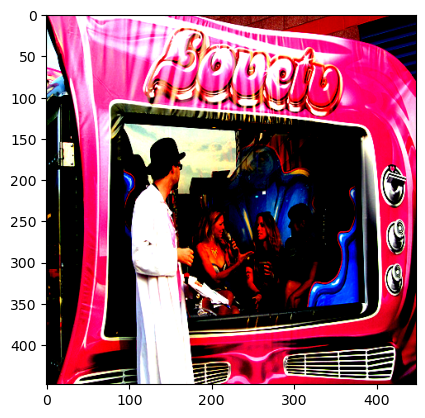

GROUND TRUTH


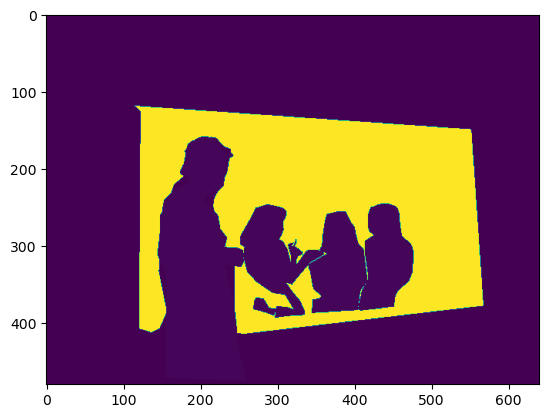

OUR SIMILARITY MAP


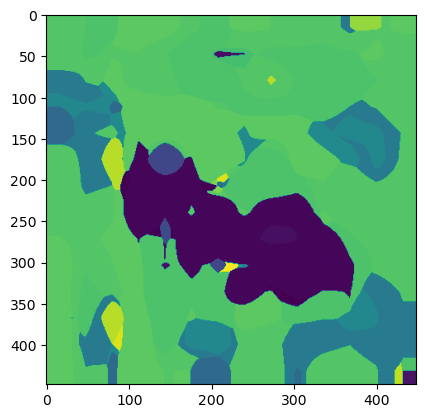

tensor([ 1,  2,  3,  4,  5, 17, 18, 19, 27, 28, 30, 31, 32, 36, 37, 42, 54, 55,
        56, 57, 62, 64, 68, 69, 72, 76], device='cuda:0')
Ours + CLIP SURGERY SIMILARITY MAP


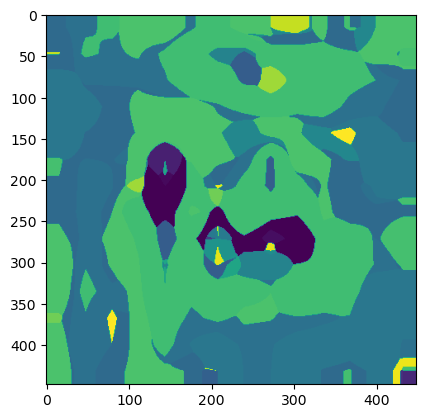

 20%|██        | 1/5 [00:00<00:01,  2.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 1,  3,  4,  8, 10, 12, 15, 24, 25, 26, 28, 29, 30, 32, 33, 36, 37, 39,
        41, 42, 47, 48, 55, 56, 57, 62, 68, 72, 75, 76, 77, 79],
       device='cuda:0')
IMAGE:


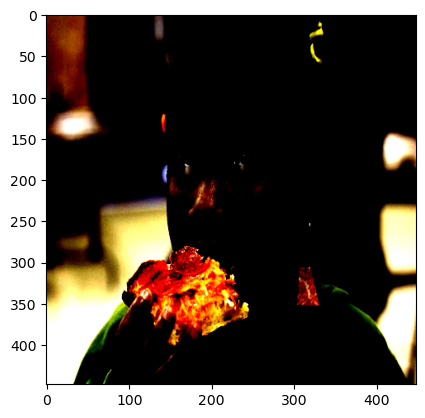

GROUND TRUTH


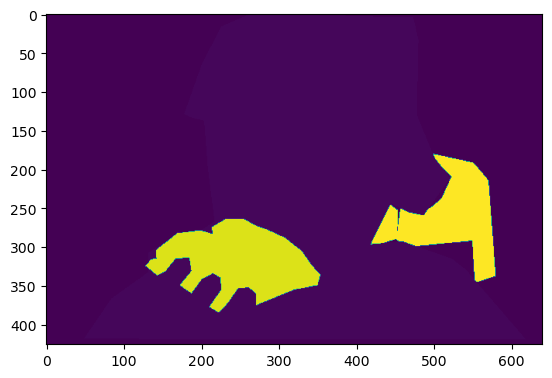

OUR SIMILARITY MAP


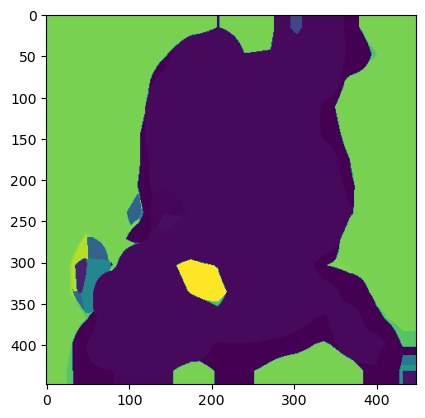

tensor([ 1,  2,  3,  4,  5,  8, 17, 25, 27, 32, 36, 42, 54, 56, 57, 61, 62, 64,
        68, 76], device='cuda:0')
Ours + CLIP SURGERY SIMILARITY MAP


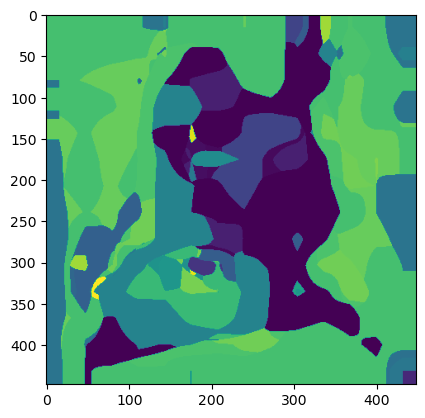

 40%|████      | 2/5 [00:00<00:01,  2.64it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 1,  3,  4,  8, 10, 13, 17, 24, 25, 27, 30, 31, 32, 33, 35, 36, 37, 39,
        40, 41, 42, 47, 54, 55, 56, 57, 59, 61, 62, 63, 64, 68, 75, 76, 79],
       device='cuda:0')
IMAGE:


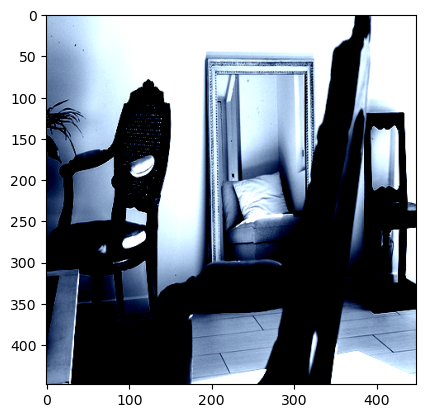

GROUND TRUTH


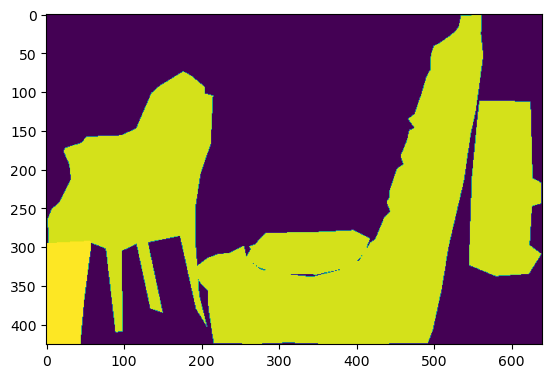

OUR SIMILARITY MAP


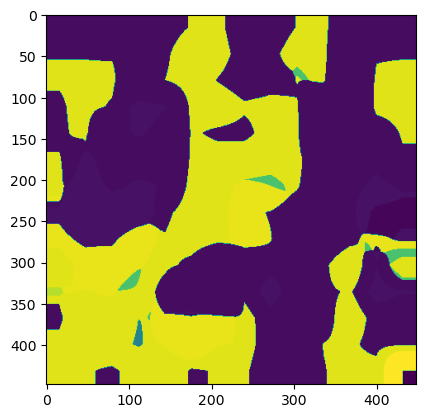

tensor([ 1,  2,  3,  4, 29, 46, 57, 61, 62, 64], device='cuda:0')
Ours + CLIP SURGERY SIMILARITY MAP


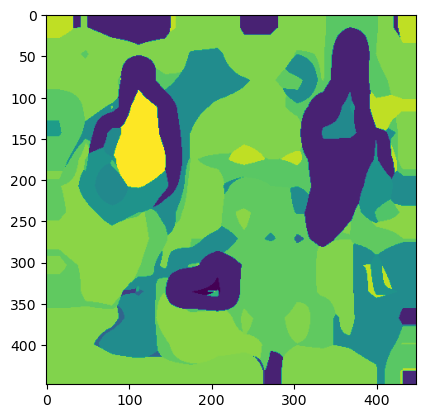

 60%|██████    | 3/5 [00:01<00:00,  2.65it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 1,  8, 10, 14, 25, 33, 36, 37, 39, 40, 41, 42, 46, 50, 54, 55, 56, 57,
        61, 62, 66, 68, 74, 75], device='cuda:0')
IMAGE:


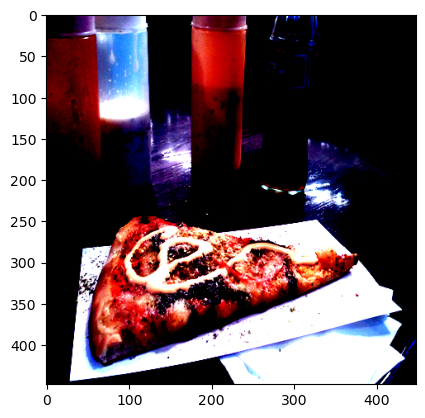

GROUND TRUTH


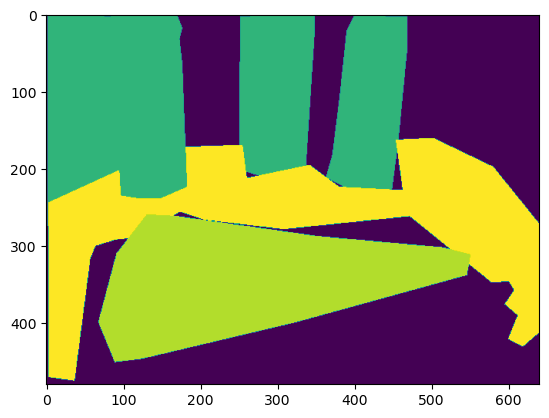

OUR SIMILARITY MAP


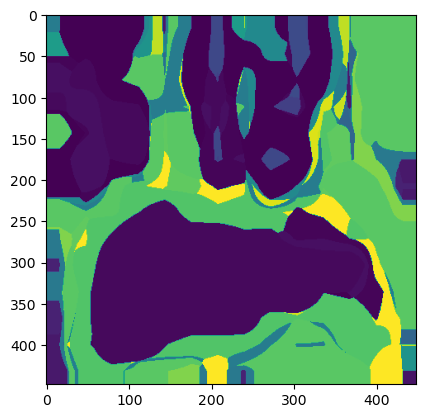

tensor([ 1,  2,  3,  4,  5,  6,  8, 15, 17, 18, 25, 27, 31, 32, 35, 36, 39, 42,
        55, 56, 57, 61, 68, 69, 71, 75], device='cuda:0')
Ours + CLIP SURGERY SIMILARITY MAP


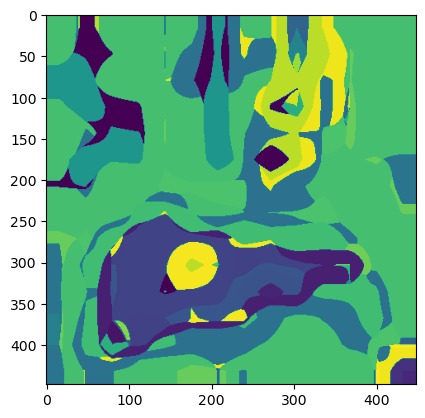

 80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

tensor([ 1,  5,  6,  8,  9, 10, 12, 16, 17, 18, 21, 22, 25, 26, 27, 28, 30, 31,
        35, 36, 39, 42, 46, 49, 50, 51, 54, 55, 56, 57, 61, 62, 65, 68, 71, 73,
        74, 75, 77, 78, 79], device='cuda:0')
IMAGE:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


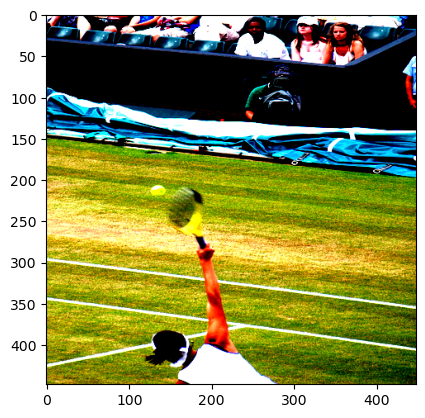

GROUND TRUTH


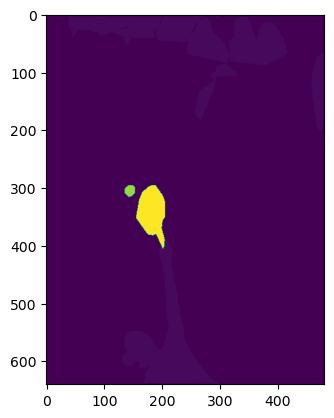

OUR SIMILARITY MAP


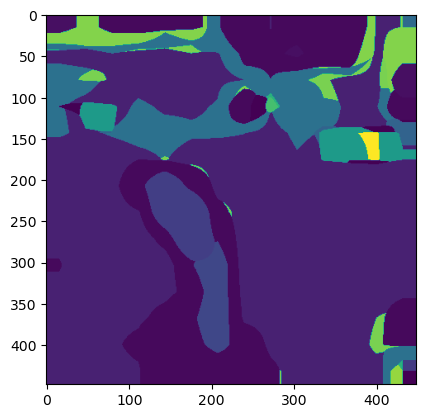

tensor([ 1,  3,  4,  8, 14, 15, 17, 25, 27, 29, 42, 49, 54, 61, 62, 64, 76],
       device='cuda:0')
Ours + CLIP SURGERY SIMILARITY MAP


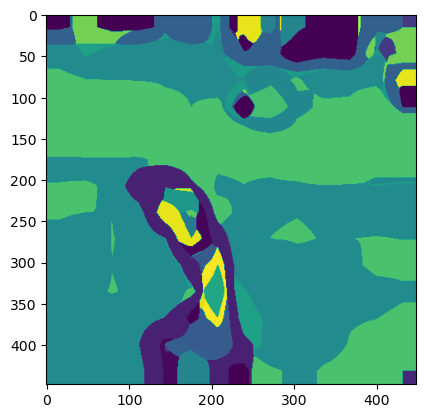

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

tensor([ 1,  2,  3,  4,  5,  8, 10, 14, 15, 17, 23, 24, 25, 26, 33, 35, 36, 37,
        38, 42, 43, 45, 47, 51, 55, 56, 59, 61, 62, 74, 75, 78],
       device='cuda:0')


In [6]:
with torch.no_grad():
    iou_scores = []
    threshold = 0.9
    metric_iou = MulticlassJaccardIndex(num_classes=len(classnames), ignore_index=0).to('cpu')
    for img_id in tqdm(image_ids[95:100]):
    # for img_id in [image_ids[129]]:
        img_info = coco.loadImgs(img_id)[0]
        img_path = image_dir + img_info['file_name']
        
        img = Image.open(img_path).convert('RGB')
        img = preprocess_img(img).to(device)
        # plt.imshow(img.permute(1,2,0).cpu())
        # plt.show()
        img = img.unsqueeze(0)
        

        true_ann_ids = coco.getAnnIds(imgIds=img_id)
        true_anns = coco.loadAnns(true_ann_ids)
        
        if len(true_anns)>0:
            
            complete_mask = np.zeros(coco.annToMask(true_anns[0]).shape, dtype=np.uint8)
            for annotation in true_anns:
                mask = coco.annToMask(annotation)
                category_id = annotation['category_id']
                our_id = classnames.index(cat_id_to_name[category_id])
                complete_mask[mask == 1] = our_id
        
        # print('UNIQUE', np.unique(complete_mask))
        # print('complete mask shape', complete_mask.shape)
        
        image_features = model.encode_image(img)
        img_feat = image_projector(image_features)
        image_features = F.normalize(img_feat, dim=-1)
        
        # image_features = img_feat
        
        text_feat = text_projector(text_feats)
        text_features = F.normalize(text_feat, dim=-1) 
        # text_features = text_feat


        features = image_features @ text_features.t()
        similarity = clip.clip_feature_surgery(image_features, text_features)

        similarity_map = clip.get_similarity_map(features[:, 1:, :], img.shape[-2:]) #complete_mask.shape)
        similarity_map_argmax = similarity_map.argmax(-1)+1

        sim_similarity_map = clip.get_similarity_map(similarity[:, 1:, :], img.shape[-2:]) #complete_mask.shape)
        sim_similarity_map_argmax = sim_similarity_map.argmax(-1)+1
        
        print('IMAGE:')
        plt.imshow(img[0].permute(1,2,0).cpu())
        plt.show()
        print('GROUND TRUTH')
        plt.imshow(complete_mask)
        plt.show()
        print('OUR SIMILARITY MAP')
        plt.imshow(similarity_map_argmax.permute(1,2,0).cpu())
        plt.show()
        print(torch.unique(similarity_map_argmax))
        print("Ours + CLIP SURGERY SIMILARITY MAP")
        plt.imshow(sim_similarity_map_argmax.permute(1,2,0).cpu())
        plt.show()
        print(torch.unique(sim_similarity_map_argmax))
        # logits_soft_max = (100*similarity_map).softmax(dim=-1).max(dim=-1)[0]
        # similarity_map_argmax[logits_soft_max < threshold] = 0 ## threshold to ignore background
        # print('similarity_map',similarity_map_argmax.shape)
        # print(torch.unique(similarity_map_argmax))
        # metric_iou.update(similarity_map_argmax.cpu(), torch.tensor(np.expand_dims(complete_mask,0)))
        # clear_output(wait=True)
        # print(metric_iou.compute().item())
        # time.sleep(0.1)

        # break
        # print(np.unique(complete_mask))
        # print(torch.unique(similarity_map_argmax))
        
        # break

In [4]:
img[0].min()

tensor(-1.7923, device='cuda:0')